#  Part 1 - Los Angeles Fire Department Responsiveness Data Exploration

Fellow Los Angelenos, have you ever wondered where all those shiny red fire trucks are headed to, loud sirens breaking your concentration as you sip your afternoon coffee?  Look no further becuase the Los Angeles Fire Department (LAFD) has made some of their [data available](https://data.lacity.org/A-Safe-City/LAFD-Response-Metrics-Raw-Data/n44u-wxe4) to the public.  The data is summarized below:




Variable |  Description
-----  |  -----
Incident Number | Each incident has a unique number.  The first 4 digits is the year the incident occurred, and the next 2 digits is the quarter.  The last 6 digits is a randomized set of numbers to uniquely identify each incident.  Thus, 201301648291 means the incident occured in the first quarter of 2013, and its unique identifying number is 648291.
First in District  |  The fire station district
Emergency Dispatch Code  |  If the incident is an emergency or non-emergency
Dispatch Sequence  |  The number assigned to each resource as it is dispatched to the incident.  Numbers can be missing if a unit is cancelled.
Dispatch Status  |  QTR = unit responded from quarters, RAD = unit responded from a radio call, AVI = unit available, ONS = unit is on scene
Unit Type  |  Type of responding unit
PPE Level  |  EMS = requires minimum personal protective equipment (PPE) and turnout time of 60 seconds, NON-EMS = requires full PPE and turnout time of 80 seconds 
Incident Creation Time  |  Time when dispatch takes the call and creates an incident report
Time of Dispatch  |  When the fire station is notified and provided instructions
En Route Time  |  Time when unit leave quarters
On Scene Time  |  Time when unit arrive at at the scene of the incident

From the original data, I also extracted the year, quarter, hour, and minute, dispatch time, turnout time, and travel times.  Due to long computational times, I've saved the processed info and am importing the processed file instead of the raw data.  Look to my pre-processing file on Github if you want to see the code.  

There were several trends I wanted to explore in order to understand the efficiency of the LAFD (and see if tax dollars are being put to good use).  

1.  Has the number of units dispatched increased over the years?  
2.  How quickly are units getting to the incident scene?  
3.  At what times are units dispatched most often?
4.  How do call volumes affect turnout time?

Lastly, I created a research proposal to implement a plan to decrease turnout time, a metric fire departments use to determine how quickly first responders get their gear together and head to the incident scene.  In this research proposal, I go through how I would implement the plan, what metrics are being evaluated, and what is considered a success in this experiment.

### 1 - Prepping the Data
The data is pretty massive, with almost 5 million rows, resulting in 4 GB of data.  In order to reduce the computational load, I downcasted,  or optimize each variable's data type, to use the least amount of memory.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("LAFD_Response_Metrics_-Processed_All.csv")

In [3]:
df.describe()

,Randomized Incident Number,First In District,Dispatch Sequence,Year,Quarter,Hour,Minute,Dispatch_time_sec,Turnout_time_sec,Travel_time_sec
count,4.978023e+06,4.977524e+06,4.978023e+06,4.978023e+06,4.978023e+06,4.978023e+06,4.978023e+06,4.978023e+06,4.977991e+06,4.977739e+06
mean,2.015907e+11,5.207892e+01,2.948812e+00,2.015876e+03,2.428264e+00,1.190605e+01,2.943736e+01,1.227134e+02,6.135679e+01,3.726103e+02
std,1.880306e+08,3.143953e+01,2.116271e+00,1.881655e+00,1.118919e+00,7.698091e+00,1.731973e+01,7.860872e+02,3.156830e+02,2.419481e+03
min,2.013016e+11,1.000000e+00,1.000000e+00,2.013000e+03,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.014046e+11,2.500000e+01,1.000000e+00,2.014000e+03,1.000000e+00,4.000000e+00,1.400000e+01,4.000000e+01,3.400000e+01,1.920000e+02
50%,2.016028e+11,5.700000e+01,3.000000e+00,2.016000e+03,2.000000e+00,1.300000e+01,2.900000e+01,6.300000e+01,5.500000e+01,2.560000e+02
75%,2.017049e+11,7.800000e+01,4.000000e+00,2.017000e+03,3.000000e+00,1.900000e+01,4.400000e+01,9.900000e+01,7.700000e+01,3.480000e+02
max,2.019029e+11,1.250000e+02,1.250000e+02,2.019000e+03,4.000000e+00,2.300000e+01,5.900000e+01,8.639600e+04,8.639900e+04,8.639900e+04


In [4]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4978023 entries, 0 to 4978022
Data columns (total 21 columns):
Randomized Incident Number      int64
First In District               float64
Emergency Dispatch Code         object
Dispatch Sequence               int64
Dispatch Status                 object
Unit Type                       object
PPE Level                       object
Incident Creation Time (GMT)    object
Time of Dispatch (GMT)          object
En Route Time (GMT)             object
On Scene Time (GMT)             object
Year                            int64
Quarter                         int64
Hour                            int64
Minute                          int64
Dispatch_time                   object
Turnout_time                    object
Travel_time                     object
Dispatch_time_sec               int64
Turnout_time_sec                float64
Travel_time_sec                 float64
dtypes: float64(3), int64(7), object(11)
memory usage: 4.0 GB


#### 1.1 - How Much Memory Does Each Data Type Take Up?
To understand better how how downcasting best reduces memory usage, I wrote a function to list out each data type and how much memory it is using.  By far, the data type that takes up the most memory are objects, at ~3.7 GB.  

Before downcasting, always double check the data types are generally correct.  For example, does a string need to be converted to an integer?  In this case, everything seems correct.  

In [5]:
def get_memoryUsage(df):
    dtype_lst = list(df.get_dtype_counts().index)
    for dtype in dtype_lst:
        print('Total memory usage for {}: {} MB'.format(dtype, format(df.select_dtypes([dtype]).memory_usage(deep = True).sum()/1024**2,'.5f')))
    
    print('\n' + 'Total Memory Usage: {} MB'.format(format(df.memory_usage(deep=True).sum()/1024**2, '.2f')))

In [6]:
get_memoryUsage(df)

Total memory usage for float64: 113.93798 MB
Total memory usage for int64: 265.85519 MB
Total memory usage for object: 3706.16082 MB

Total Memory Usage: 4085.95 MB


##### 1.1.1 - Downcasting Numeric Data
Since none of the variables are less than 0, I can downcast integers to an unsigned data type.  Downcasting numeric data types doesn't help too much with the memory usage however. But that was expected since most of the memory usage came from objects.

In [7]:
def downcast_Numeric(df):
    for col in df.select_dtypes(['int64']):
        df[col] = pd.to_numeric(df[col], downcast = 'unsigned')
    for col in df.select_dtypes(['float64']):
        df[col] = pd.to_numeric(df[col], downcast = 'float')

In [8]:
downcast_Numeric(df)

In [9]:
get_memoryUsage(df)

Total memory usage for float32: 56.96903 MB
Total memory usage for object: 3706.16082 MB
Total memory usage for uint16: 9.49490 MB
Total memory usage for uint32: 0.00008 MB
Total memory usage for uint64: 37.97938 MB
Total memory usage for uint8: 18.98973 MB

Total Memory Usage: 3848.58 MB


##### 1.1.2 - Downcasting Objects
Downcasting objects to categories doesn't always optimize memory usage; sometimes, it can take up even more memory!  This is the case if the number of unique values is more than half the length of the column.  Thus for this dataset, only Incident Creation Time was converted to category.  Even so, the total memory usage dropped from 4 GB to 2.4 GB, a 40% decrease in memory usage.

In [10]:
def downcast_Obj(df):
    for col in df.select_dtypes(['object']):
        if df[col].nunique() < len(df[col])/2:
            df[col] = df[col].astype('category')

In [11]:
downcast_Obj(df)

In [12]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4978023 entries, 0 to 4978022
Data columns (total 21 columns):
Randomized Incident Number      uint64
First In District               float32
Emergency Dispatch Code         category
Dispatch Sequence               uint8
Dispatch Status                 category
Unit Type                       category
PPE Level                       category
Incident Creation Time (GMT)    category
Time of Dispatch (GMT)          object
En Route Time (GMT)             object
On Scene Time (GMT)             object
Year                            uint16
Quarter                         uint8
Hour                            uint8
Minute                          uint8
Dispatch_time                   object
Turnout_time                    object
Travel_time                     object
Dispatch_time_sec               uint32
Turnout_time_sec                float32
Travel_time_sec                 float32
dtypes: category(5), float32(3), object(6), uint16(1), uint

In [14]:
get_memoryUsage(df)

Total memory usage for category: 158.40734 MB
Total memory usage for float32: 56.96903 MB
Total memory usage for object: 2119.23072 MB
Total memory usage for uint16: 9.49490 MB
Total memory usage for uint32: 0.00008 MB
Total memory usage for uint64: 37.97938 MB
Total memory usage for uint8: 18.98973 MB

Total Memory Usage: 2420.06 MB


### 2 - Has the Number of Units Dispatched Increased Over the Years?
I was interested in finding out if the LAFD resources were being utilized more because of the increasing population in LA as well as the more brutal wildfires popping up in recent years.  

Just how far back does this data go?  The year and quarter are cleverly hidden in the incident number.  After extracting the data, I found that the data starts in the first quarter of 2013 to the second quarter of 2019.

In [13]:
print('Data was collected from {} quarter {} to {} quarter {}.'.format(df['Year'].min(), 
                                                 df[(df['Year']== df['Year'].min())]['Quarter'].min(),
                                                 df['Year'].max(),
                                                df[(df['Year']== df['Year'].max())]['Quarter'].max()))

Data was collected from 2013 quarter 1 to 2019 quarter 2.


Now that we have a time frame, just how busy has LAFD been since 2013?  The left plot below shows they have been quite busy.  **The number of units dispatched in 2013 was ~700k, but that number has increased to ~800k in 2018.**  2019 is only halfway through, but it seems to be on track to beat the number of dispatched units in 2018.  

The plot on the right is a similar graph, but splits is split by PPE level.  PPE levels just dictates how much time the emergency personnel have before leaving for the scene of the incident.  For emergency medical services (EMS), this means they have 60 seconds, and for non-EMS, they have 80 seconds.  While the number of non-EMS incidents has stayed relatively steady, the number of EMS incidents has been increasing.  Considering EMS incidents have the shorter time limit and increased number of incidents, it is critical that emergency personnel head to the scene as quickly as possible.  

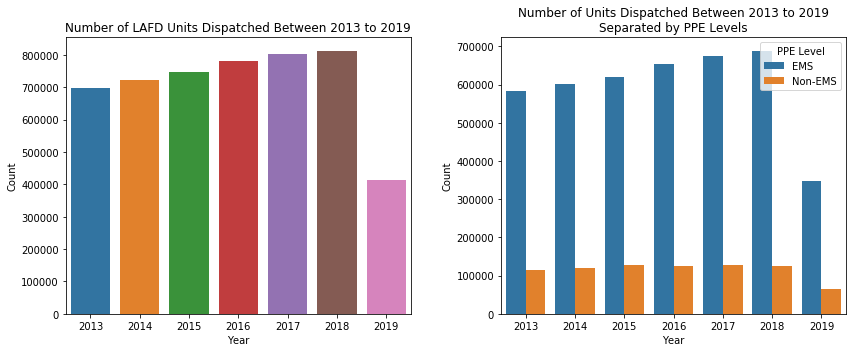

In [14]:
fig, (axis1, axis2) = plt.subplots(1,2,figsize=(12,5))

sns.countplot(x = 'Year', data = df, ax = axis1)
sns.countplot(x = 'Year', hue = 'PPE Level', data = df, ax = axis2)

axis1.set_title('Number of LAFD Units Dispatched Between 2013 to 2019')
axis2.set_title('Number of Units Dispatched Between 2013 to 2019\nSeparated by PPE Levels')

for ax in [axis1, axis2]:
    ax.set_xlabel('Year')
    ax.set_ylabel('Count')

plt.tight_layout()

### 3 - How Quickly are Units Getting to the Incident Scene?
There are three time related metrics that are of concern to fire departments:

-  Dispatch time: Time elapsed from when a call is received at the 9-1-1 center until units are notified.
-  Turnout time: Time elapsed from when units are notified until they are headed to the scene.
-  Travel time: Time elapsed from when units head to the scene until they arrive at the scene.

I've also added a new column called total time that simply adds up the dispatch, turnout, and travel times.  This total time indicates how quickly units are getting to the scene.

In [25]:
df['Total_time_sec'] = df.apply(lambda x: x['Dispatch_time_sec'] + x['Turnout_time_sec'] + x['Travel_time_sec'], axis =1)

LAFD shifts start at 8am, and each shift is 24 hours.  As such, I've split the hours of the day into 4 time periods starting at 8am instead of the traditional morning/afternoon/evening scheme to do further analysis on each time frame.

In [18]:
def time_of_day(hr):
    if (hr >7) & (hr < 14):
        return '8am-1pm'
    elif (hr < 20) & (hr >=14):
        return '2pm-7pm'
    elif (hr >=20) | (hr < 2):
        return '8pm-1am'
    elif (hr < 8) & (hr > 1):
        return '2am-7am'

In [19]:
df['time_of_day'] = df['Hour'].apply(time_of_day)

Below are four box plots that show the distribution of times for total, dispatch, turnout, and travel times.  

For total time, the time period between 8am to 1pm has the slowest total response time, but then it seems to even out for the rest of the day, with a slight increase from 2am to 7am.  **Overall, from the time a call is received to the time a unit arrives on scene, it takes about 400 seconds, or 6.6 minutes.**

Looking at the breakdown for dispatch time and travel times, there isn't too much variation.  That means the variation comes from turnout time, and indeed, the breakdown for turnout time shows that emergency personnel are slowest from 8am to 1pm, but they seem to reach their max speed between 2pm and 1am, but then slow down again at the end of their shift between 2am to 7am.  
 

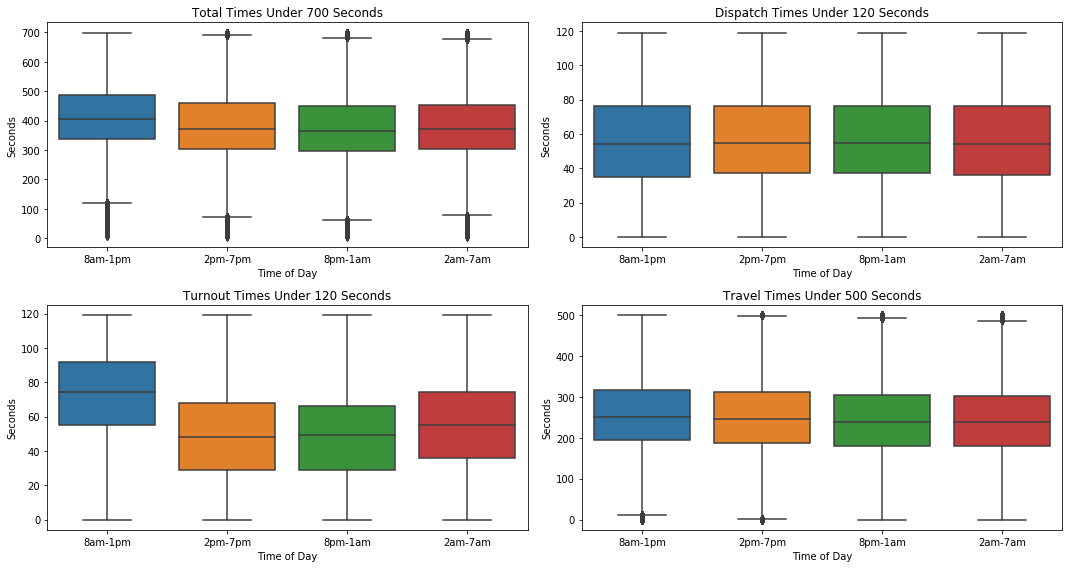

In [23]:
fig, ((axis1, axis2), (axis3, axis4)) = plt.subplots(2,2,figsize=(15,8))

time_of_day_order = ['8am-1pm', '2pm-7pm', '8pm-1am', '2am-7am']
sns.boxplot(x = 'time_of_day', y = 'Total_time_sec', order = time_of_day_order,
            data = df[df['Total_time_sec']<700], ax = axis1)
sns.boxplot(x = 'time_of_day', y = 'Dispatch_time_sec', order = time_of_day_order,
            data = df[df['Dispatch_time_sec']<120], ax = axis2)
sns.boxplot(x = 'time_of_day', y = 'Turnout_time_sec', order = time_of_day_order,
            data = df[df['Turnout_time_sec']<120], ax = axis3)
sns.boxplot(x = 'time_of_day', y = 'Travel_time_sec', order = time_of_day_order,
            data = df[df['Travel_time_sec']<500], ax = axis4)

axis1.set_title('Total Times Under 700 Seconds')
axis2.set_title('Dispatch Times Under 120 Seconds')
axis3.set_title('Turnout Times Under 120 Seconds')
axis4.set_title('Travel Times Under 500 Seconds')

for ax in [axis1, axis2, axis3, axis4]:
    ax.set_xlabel('Time of Day')
    ax.set_ylabel('Seconds')
    
plt.tight_layout()

Although the average turnout time is still under the suggested 80 seconds, this process is still not optimized.  Lets zoom into the hours for the first and last shifts for 2018 and 2019, as those are the time frames where the most improvement can be made.

#### 3.1 - A Closer Look at Turnout Times Between 8am and 1pm
Below are four graphs depicting turnout times between the hours of 8am and 1pm.  The top row shows the mean (upper left) and median (upper right) turnout times separated by year.  For both the mean and median, it is clear that the turnout time decreases as we get closer to the present date, which is great!  LAFD has recognized a problem and were working hard to decrease their turnout time.  The other thing to notice is that the plot showing the means has a lot more peaks and dips, mainly at 9am and at noon before dipping at 1pm.  This is contrast to the median plot, which has a smooth increase until noon, where a decrease happens, also at 1pm.  This tells us that the turnout data is highly skewed. Stats are shown in the describe function in the intro section, but as an example, in 2018, the turnout times ranged from 0 to 86399 seconds, or 23.99 hours.  Medians are less affected by outliers and thus, the graph is smoother.  In addition, median values are lower than the mean, again because the median is not as affected by outliers.  

Without access to someone in LAFD, it is difficult to identify exactly why turnout times are higher than average between 8am and 12pm.  However, a possible explanation is that this is when the new shift is checking their equipment, washing trucks, or replacing saws and batteries.  If a call comes in while they are in the middle of a check, then its plausible that an extra 10-20 seconds is needed to make sure all the equipment is ready before leaving the station.

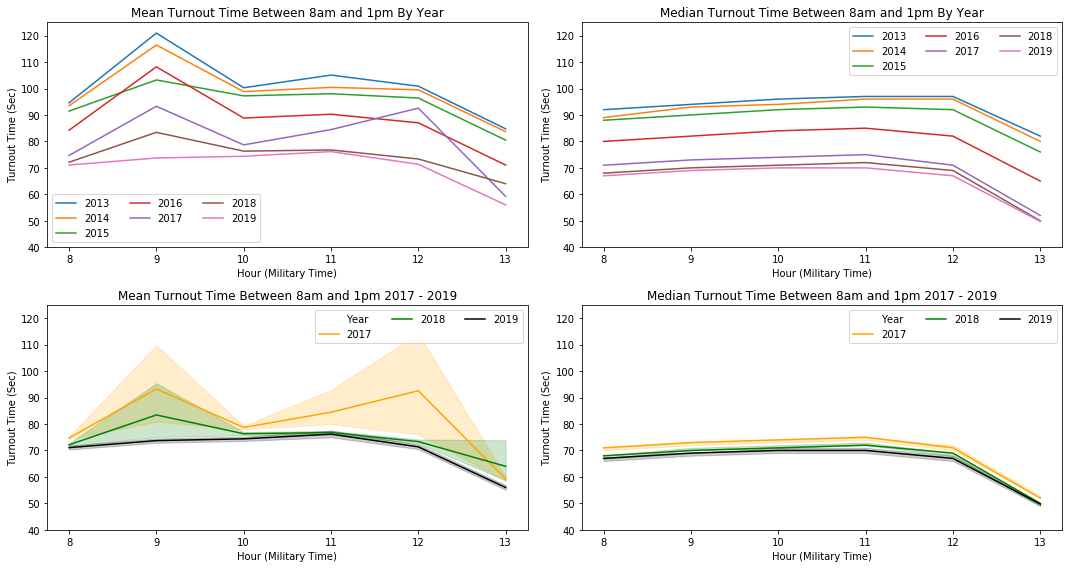

In [72]:
fig, ((axis1, axis2), (axis3, axis4)) = plt.subplots(2,2,figsize=(15,8))

df[df['time_of_day'] == '8am-1pm'].groupby(['Hour', 'Year']).mean()['Turnout_time_sec'].unstack().plot(ax = axis1)
df[df['time_of_day'] == '8am-1pm'].groupby(['Hour', 'Year']).median()['Turnout_time_sec'].unstack().plot(ax = axis2)
sns.lineplot(x = 'Hour', y = 'Turnout_time_sec', 
             data = df[(df['time_of_day'] == '8am-1pm') & ((df['Year'] == 2017) |(df['Year'] == 2018) | (df['Year'] == 2019))], 
             hue = 'Year', palette = ['orange', 'green', 'black'], estimator = np.mean , ax = axis3)
sns.lineplot(x = 'Hour', y = 'Turnout_time_sec', 
             data = df[(df['time_of_day'] == '8am-1pm') & ((df['Year'] == 2017) |(df['Year'] == 2018) | (df['Year'] == 2019))], 
             hue = 'Year', palette = ['orange', 'green', 'black'], estimator = np.median , ax = axis4)

axis1.set_title('Mean Turnout Time Between 8am and 1pm By Year')
axis2.set_title('Median Turnout Time Between 8am and 1pm By Year')
axis3.set_title('Mean Turnout Time Between 8am and 1pm 2017 - 2019')
axis4.set_title('Median Turnout Time Between 8am and 1pm 2017 - 2019')

for ax in [axis1, axis2, axis3, axis4]:
    ax.set_xlabel('Hour (Military Time)')
    ax.set_ylabel('Turnout Time (Sec)')
    ax.set_ylim([40,125])
    ax.legend(ncol = 3)
    
plt.tight_layout()

In [74]:
print('Turnout times in 2018 ranges from {} to {}'.format(df[df['Year']==2018]['Turnout_time_sec'].min(), df[df['Year']==2018]['Turnout_time_sec'].max()))

Turnout times in 2018 ranges from 0.0 to 86399.0


The bottom half of the above plot is the same graph as the top row but with confidence intervals for years 2017 to 2019.  For the means plot (bottom left), we see that the confidence intervals vary greatly compared to the median plot (bottom right).  It also seems that the confidence intervals in the means plot gets smaller as time gets closer to present day.  The confidence interval for 2019 actually looks very thin, similar to the confidence interval for the median plot.  However, one must be careful when comparing incomplete data such as 2019.  

Below, I've plotted turnout times with confidence intervals for 2018.  The first graph (left) shows the mean turnout time for the first half of 2018 while the second graph (middle) is the turnout time for the second half of 2018.  While the mean is generally similar for the two halves, the confidence intervals vary greatly.  The third graph (right) is the mean with confidence interval for the whole of 2018; it looks quite different from the left graph.  

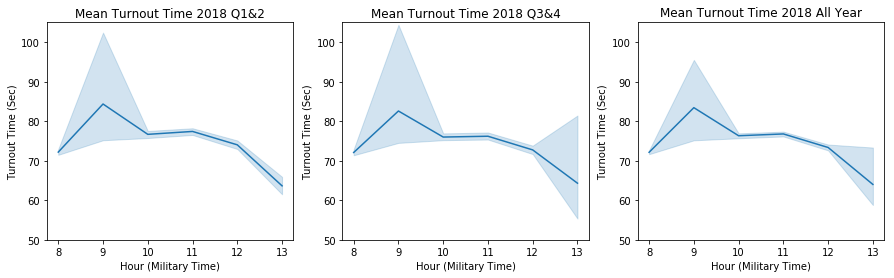

In [76]:
fig, (axis1, axis2, axis3) = plt.subplots(1,3,figsize=(15,4))

sns.lineplot(x = 'Hour', y = 'Turnout_time_sec', 
             data = df[(df['time_of_day'] == '8am-1pm') & (df['Year'] == 2018) & ((df['Quarter'] == 1) | (df['Quarter'] == 2))], ax = axis1)
sns.lineplot(x = 'Hour', y = 'Turnout_time_sec', 
             data = df[(df['time_of_day'] == '8am-1pm') & (df['Year'] == 2018) & ((df['Quarter'] == 3) | (df['Quarter'] == 4))], ax = axis2)
sns.lineplot(x = 'Hour', y = 'Turnout_time_sec', 
             data = df[(df['time_of_day'] == '8am-1pm') & (df['Year'] == 2018)], ax = axis3)

axis1.set_title('Mean Turnout Time 2018 Q1&2')
axis2.set_title('Mean Turnout Time 2018 Q3&4')
axis3.set_title('Mean Turnout Time 2018 All Year')


for ax in [axis1, axis2, axis3]:
    ax.set_ylabel('Turnout Time (Sec)')
    ax.set_xlabel('Hour (Military Time)')
    ax.set_ylim([50,105])

#### 3.2 - A Closer Look at Turnout Time Between 2am and 7am
Below are four plots depicting turnout times between 2am and 7am (similar to the analysis of turnout times between 8am and 1pm in section 3.1).  In the top row, we see again that for both mean (upper left) and median (upper right) plots, the turnout times decrease from 2013 to 2019.  However, there are less peaks and dips in means plot compared to the 8am to 1pm time frame.  Confidence intervals in the lower half of the figure also shows smaller variation.  

It should be noted that from 2am to 7am, the turnout time steadily increases.  This is most likely due to fatigue, as it is very hard both mentally and physically to perform at peak performance when you are being woken up on average every 2 hours.  

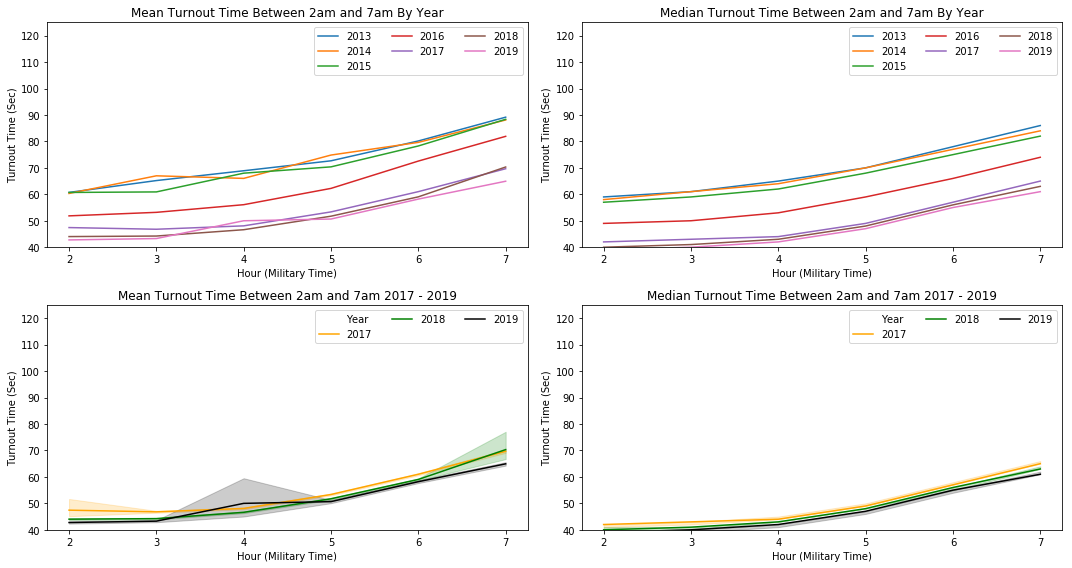

In [80]:
fig, ((axis1, axis2), (axis3, axis4)) = plt.subplots(2,2,figsize=(15,8))

df[df['time_of_day'] == '2am-7am'].groupby(['Hour', 'Year']).mean()['Turnout_time_sec'].unstack().plot(ax = axis1)
df[df['time_of_day'] == '2am-7am'].groupby(['Hour', 'Year']).median()['Turnout_time_sec'].unstack().plot(ax = axis2)
sns.lineplot(x = 'Hour', y = 'Turnout_time_sec', 
             data = df[(df['time_of_day'] == '2am-7am') & ((df['Year'] == 2017) |(df['Year'] == 2018) | (df['Year'] == 2019))], 
             hue = 'Year', palette = ['orange', 'green', 'black'], estimator = np.mean , ax = axis3)
sns.lineplot(x = 'Hour', y = 'Turnout_time_sec', 
             data = df[(df['time_of_day'] == '2am-7am') & ((df['Year'] == 2017) |(df['Year'] == 2018) | (df['Year'] == 2019))], 
             hue = 'Year', palette = ['orange', 'green', 'black'], estimator = np.median , ax = axis4)

axis1.set_title('Mean Turnout Time Between 2am and 7am By Year')
axis2.set_title('Median Turnout Time Between 2am and 7am By Year')
axis3.set_title('Mean Turnout Time Between 2am and 7am 2017 - 2019')
axis4.set_title('Median Turnout Time Between 2am and 7am 2017 - 2019')

for ax in [axis1, axis2, axis3, axis4]:
    ax.set_xlabel('Hour (Military Time)')
    ax.set_ylabel('Turnout Time (Sec)')
    ax.set_ylim([40,125])
    ax.legend(ncol = 3)
    
plt.tight_layout()

###  4 - What Time are Units Dispatched Most Often?
I wanted to know which types of units were dispatched most and if there were specific times of the day a unit was dispatched more.  Below, I've plotted the number of times a specific unit was dispatched for 2018 (left) and the first half of 2019 (right).  For both years, no specific unit is dispatched more at a certain time.  Instead, all four units (fire engine, fire truck, and 2 types of ambulances) follow the same trend where there is a high at midnight, steadily decreases until around noon, and starts rising again until midnight.  

The two units that are dispatched most with similar frequencies are fire engines (the vehicle that pumps water), and advanced life support (ALS) ambulances.  The next two units that are most frequently dispatched are the basic life support (BLS) ambulance and fire trucks (the vehicle that carries ladders).  

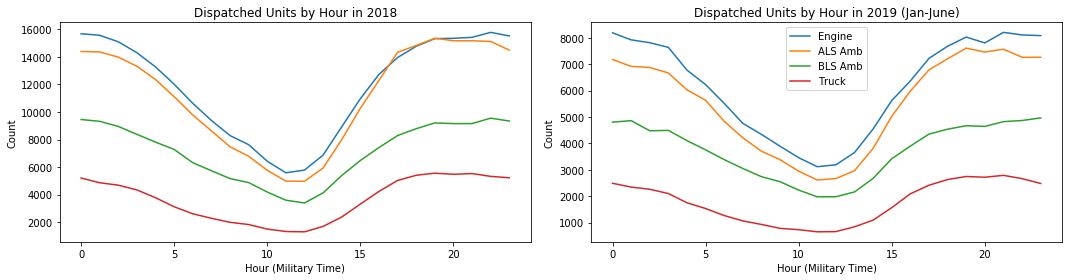

In [84]:
fig, (axis1, axis2) = plt.subplots(1,2,figsize=(15,4))

df[(df['Year']==2018) & (df['Unit Type'] == 'Engine')].groupby('Hour').count()['Unit Type'].plot(label = 'Engine', ax = axis1)
df[(df['Year']==2018) & (df['Unit Type'] == 'ALS Amb')].groupby('Hour').count()['Unit Type'].plot(label = 'ALS Amb', ax = axis1)
df[(df['Year']==2018) & (df['Unit Type'] == 'BLS Amb')].groupby('Hour').count()['Unit Type'].plot(label = 'BLS Amb', ax = axis1)
df[(df['Year']==2018) & (df['Unit Type'] == 'Truck')].groupby('Hour').count()['Unit Type'].plot(label = 'Truck', ax = axis1)

df[(df['Year']==2019) & (df['Unit Type'] == 'Engine')].groupby('Hour').count()['Unit Type'].plot(label = 'Engine', ax = axis2)
df[(df['Year']==2019) & (df['Unit Type'] == 'ALS Amb')].groupby('Hour').count()['Unit Type'].plot(label = 'ALS Amb', ax = axis2)
df[(df['Year']==2019) & (df['Unit Type'] == 'BLS Amb')].groupby('Hour').count()['Unit Type'].plot(label = 'BLS Amb', ax = axis2)
df[(df['Year']==2019) & (df['Unit Type'] == 'Truck')].groupby('Hour').count()['Unit Type'].plot(label = 'Truck', ax = axis2)

axis1.set_title('Dispatched Units by Hour in 2018')
axis2.set_title('Dispatched Units by Hour in 2019 (Jan-June)')

for ax in [axis1, axis2]:
    ax.set_xlabel('Hour (Military Time)')
    ax.set_ylabel('Count')

plt.legend()
plt.tight_layout()

### 5 - How do Call Volumes Affect Turnout Time?
The last thing I wanted to explore was if a district's call volume, or the number of calls the district received over a year, affected its turnout time.  Below, I've plotted each district's median turnout time against its call volume.  Although non-ems situations allow 80 seconds for turnout time, it looks like the LAFD is trying to have a turnout time of 60 seconds or less no matter what the situation is.  Thus, I've included a horizontal dotted black line at 60 seconds, and a horizontal dotted green line at the median turnout time.  Districts with turnout times over the black line are considered slow whereas the districts with turnout times under the green line are considered fast.  Distrits with turnout times in between the two lines are considered medium speed.  

**There isn't a nice linear relationship between call volume and turnout times.**  What I do notice is that for 2018 (left), the slow districts all had call volumes of ~3200 or less, and for 2019 (right), slow districts had call volumes of ~1500 or less.  These call volumes are indicated by the orange vertical line.  That isn't to say that all the districts to the left of the orange line is slow.  Most of them were of medium speed, and some were even fast.  It does say however, that unless the slow districts have drastically different layouts in the station, perhaps they could do with some more drills.  

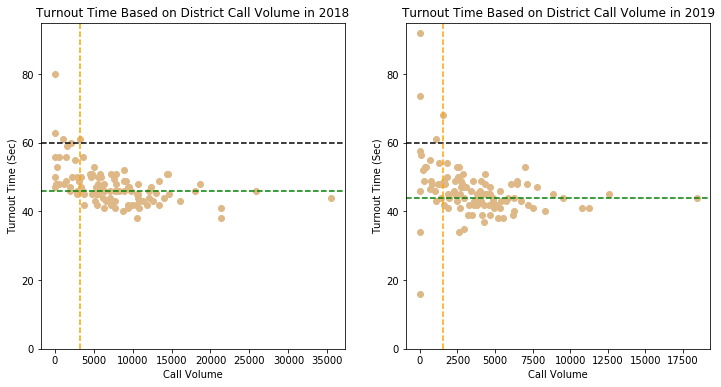

In [100]:
fig, (axis1, axis2) = plt.subplots(1,2,figsize=(12,6))

axis1.scatter(x = df[df['Year'] == 2018].groupby(['Year', 'First In District']).count()['Turnout_time_sec'].unstack().values,
           y = df[df['Year'] == 2018].groupby(['Year', 'First In District']).median()['Turnout_time_sec'].unstack().values,
             color = 'burlywood')
axis2.scatter(x = df[df['Year'] == 2019].groupby(['Year', 'First In District']).count()['Turnout_time_sec'].unstack().values,
           y = df[df['Year'] == 2019].groupby(['Year', 'First In District']).median()['Turnout_time_sec'].unstack().values,
             color = 'burlywood')

axis1.set_title('Turnout Time Based on District Call Volume in 2018')
axis2.set_title('Turnout Time Based on District Call Volume in 2019')

for ax in [axis1, axis2]:
    ax.set_ylabel('Turnout Time (Sec)')
    ax.set_xlabel('Call Volume')
    ax.set_ylim([0,95])
    ax.axhline(60, ls = '--', color = 'black')
axis1.axhline(df[df['Year'] == 2018]['Turnout_time_sec'].median(), ls = '--', color = 'green')
axis1.axvline(3217, ls = '--', color= 'orange')
axis2.axhline(df[df['Year'] == 2019]['Turnout_time_sec'].median(), ls = '--', color = 'green')
axis2.axvline(1562, ls = '--', color = 'orange')

# Part 2 - The Research Proposal
What can we do to lower turnout times, specifically between 2am and 12pm when fatigue sets in and when a new shift starts?  Even when a new solution is implemented, how can we identify if the new solution worked?  This is where AB testing comes in.  In the following sections, I will state the problem, provide a potential solution, and explain how to evaluate if the solution was successful or not.

### 1 - The Problem
In the event of an emergency such as a heart attack or fire, every second counts.  Thus, it is imperative that first responders arrive at the scene as quickly and efficiently as possible.  In the case of LAFD, their turnout times are not optimized.  **How can LAFD reduce their turnout time?**

### 2 - The Potential Solution
Currently, LAFD shifts last 24 hours and the shift changes at 8am.  There are two time periods of inefficient turnout times: 1)  right after the shift change between 8am and 12pm, possibly due to equipment checks, and 2) between 2am to 7pm due to fatigue.  **The proposed solution is two fold:**
1.  There will be two overlapping 24 hour shifts, one starting at 8am and the other at 8pm.  
2.  For those in the first half of their shift, they will be assigned to the busier units (Engines and ALS ambulances).  For those in the second half of their shift, they will be assigned to the less busy units (BLS ambulance and Truck).  

### 3 - The Method of Testing the Solution
In order to test if the overlapping shifts reduce turnout time, an AB test should be performed.  Ideally, half of the districts will adopt the overlapping shifts, making sure that slow, medium, and fast districts are included in the test population.  However, to ease firefighters into the new schedule, a roll out plan will be implemented.  For the first month, 1/4 of the districts will be on the new schedule.  

#### 3.1 - Rollout Plan
Before the rollout plan is even implemented, we need to gather information.  Specifically, **we need the turnout times from each district in the test and control groups.**  This is so we can compare turnout times before and during the testing period.

**The rollout plan will be in two phases.**  The first phase involves implementing the new schedule to 1/4 of the districts for one month.  If there are no severe consequences such as an increase in traffic accidents or missing equipment on calls, then another 1/4 of the district can implement the new schedule.  At this point, half the district should be on the new schedule, and this second phase should go for two months.  Overall, the testing period is 3 months, or one quarter.  Based on 2017 and 2018 data, the number of test samples is 80,000+.   

#### 3.2 - Metrics
**Success Metric**  
When the testing period is finished, a t-test should be performed, with a p-value of 0.05.  Here, the null hypothesis is that the median of the test turnout time is equal to the median of the control turnout time.  The alternative hypothesis is that the mean of the test turnout time is NOT equal to the median of the control turnout time.  

**Secondary Metric**  
Another metric to look at would be to see if all test districts were able to get their turnout times under 60 seconds.  

#### 3.3 - Evaluating the Experiment
Based on the t-test, there are two outcomes.  

1.  If the p-value is greater than 0.05, then accept the null hypothesis.  
    1.  This means the new schedule is not effective and test districts should be reverted back to the original, non-overlapping 24 hour shifts.
2.  If the p-value is less than 0.05, then reject the null hypothesis.  
    2.  This means the new schedule is effective at reducing turnout times and should be implemented in all districts.